# Dpi Setting

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


In [6]:
import os

print(os.getcwd())

/home/divar/projects/graphical-sampling/Simulations


In [7]:
import os
os.chdir('/home/divar/projects/graphical-sampling')

### Dependencies

### Python

In [8]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [9]:
!apt-get install -y r-base
#!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [10]:
from rpy2.robjects.packages import importr

import numpy as np
from rpy2.robjects import numpy2ri, default_converter, globalenv
from rpy2.robjects.conversion import localconverter

In [11]:
%load_ext rpy2.ipython

### R

In [12]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling


### Imports

In [13]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Scores in R

In [14]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
      globalenv['sample_mask'] = sample_mask
      globalenv['sample_idx'] = sample_idx + 1  # Or int(sample_idx + 1) if it's just one value
      globalenv['coords'] = coords
      globalenv['probs'] = probs
      globalenv['n'] = n
      globalenv['N'] = N
    # ro.globalenv['sample_mask'] = sample_mask
    # ro.globalenv['sample_idx'] = sample_idx + 1
    # ro.globalenv['coords'] = coords
    # ro.globalenv['probs'] = probs
    # ro.globalenv['n'] = n
    # ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], IB_value, SBLB_value
    # return scores[0][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

### Functions

In [15]:
autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n = 10  # Number of clusters
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = n
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)
plasma_colors = light_colors

In [16]:
def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None


# Simulations

### Methods

In [25]:
import numpy as np
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri

# Enable the numpy <-> R conversion
#rpy2.robjects.numpy2ri.activate()

def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method (BalancedSampling)
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    # Placeholder, replace with your actual method if necessary
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, tolerance=2, split_size=0.001).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    # Placeholder, replace with your own implementation if available
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs
    n = int(round(np.sum(probs)))

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
mask <- UPmaxentropy(probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx



def spcosa_samples(coords, n, num_samples):
    """
    Uses the spcosa R package for equal probability spatially balanced sampling.
    """
    ro.globalenv['coords'] = coords
    N = coords.shape[0]
    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = f"""
library(spcosa)
set.seed({np.random.randint(1, 1e8)})
df <- data.frame(x = coords[,1], y = coords[,2])
coordinates(df) <- ~x + y
gridded(df) <- TRUE
stratification <- stratify(df, nStrata = {n}, nTry = 50)
samples <- spsample(stratification)
# Extract row indices in original data
whichrow <- as.integer(rownames(as(samples, "data.frame")))
"""
        ro.r(r_code)
        sample_idx = np.array(ro.r("whichrow")) - 1  # zero-based for Python
        samples_idx[i] = sample_idx
    return samples_idx


def find_samples(coords, probs, n, num_samples, ep_mode="auto"):
    """
    Returns a dict of various sampling methods. 
    If ep_mode=="auto", heuristically deduce EP/UP from probs.
    """
    # Determine if this is the EP case: uniform probs and sum ~ n
    #is_EP = np.allclose(probs, probs[0]) and np.isclose(np.sum(probs), n)
    result = {
        "K-Means (45_random_)": k_means_samples(coords, probs, n, num_samples, (4, 5)),
        "K-Means (11_random_)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        # "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        # "Random": random_samples(coords, probs, n, num_samples),
        # "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
        }
    # if is_EP or ep_mode=="EP":
    #     result["spcosa"] = spcosa_samples(coords, n, num_samples)
    return result

### Gathering Data

In [23]:
import pandas as pd
import os

results_folder = 'data_samples/results'
result_files = [
    "results_grid_eq.csv",
    "results_grid_uneq.csv",
    "results_random_eq.csv",
    "results_random_uneq.csv",
    "results_clust_eq.csv",
    "results_clust_uneq.csv",
]

methods_to_remove = ["K-Means (45_random_)", "K-Means (11_random_)"]

for filename in result_files:
    filepath = os.path.join(results_folder, filename)
    df = pd.read_csv(filepath)
    # Remove rows where the 'Method' column matches the unwanted method
    df_filtered = df[~df['Method'].isin(methods_to_remove)]

    # Save back (overwrite the original file; change filename if you want a backup)
    df_filtered.to_csv(filepath, index=False)
    print(f"Filtered {filename}: {len(df) - len(df_filtered)} rows removed.")

Filtered results_grid_eq.csv: 2010 rows removed.
Filtered results_grid_uneq.csv: 4000 rows removed.
Filtered results_random_eq.csv: 4000 rows removed.
Filtered results_random_uneq.csv: 2010 rows removed.
Filtered results_clust_eq.csv: 2010 rows removed.
Filtered results_clust_uneq.csv: 4000 rows removed.


In [27]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
    "clust_eq", "clust_uneq",
    "grid_eq", "grid_uneq",
    "random_eq", "random_uneq"
]
# names = [
#     "swiss_uneq",
#     ]
#names = ["random_uneq"]
for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)
print(sum(probs))
print(len(probs))
sample_cnt = 1000
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]
columns = ["Method", "Density", "Moran", "Local Balance"]

for coords, probs, name in zip(all_coords, all_probs, names):
    n = int(np.round(np.sum(probs)))
    N =len(probs)
    # Any code for one set, put here:
    sample_methods = find_samples(coords, probs, n, sample_cnt)
    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    rows = np.array([
    [method, *scores(coords, probs, n, N, s, density_measure)]
    for method, samples in sample_methods.items()
    if samples is not None  # <----- add this
    for s in tqdm(samples, total=sample_cnt)
])
    df = pd.DataFrame(rows, columns=columns)
    df = df.astype({
        "Density": float,
        #"Voronoi": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"initial_results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

3.9999999999999782
400


100%|██████████| 1000/1000 [24:10<00:00,  1.45s/it]


Saved: data_samples/results/initial_results_clust_eq.csv


/home/divar/projects/graphical-sampling/geometric_sampling/sampling/popu.py:156: RuntimeWarning: divide by zero encountered in scalar divide
  probs_stabled *= 1 / (np.sum(probs_stabled) * np.prod(self.n_zones))
/home/divar/projects/graphical-sampling/geometric_sampling/sampling/popu.py:156: RuntimeWarning: invalid value encountered in multiply
  probs_stabled *= 1 / (np.sum(probs_stabled) * np.prod(self.n_zones))
100%|██████████| 1000/1000 [18:35<00:00,  1.12s/it]


Saved: data_samples/results/initial_results_clust_uneq.csv


100%|██████████| 1000/1000 [22:10<00:00,  1.33s/it]


Saved: data_samples/results/initial_results_grid_eq.csv


100%|██████████| 1000/1000 [33:48<00:00,  2.03s/it]


Saved: data_samples/results/initial_results_grid_uneq.csv


100%|██████████| 1000/1000 [24:02<00:00,  1.44s/it]


Saved: data_samples/results/initial_results_random_eq.csv


100%|██████████| 1000/1000 [20:19<00:00,  1.22s/it]

Saved: data_samples/results/initial_results_random_uneq.csv


In [32]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
     "grid_eq", "grid_uneq",
    "clust_eq", "clust_uneq",
    "random_eq", "random_uneq"
]
# names = [
#     "swiss_uneq",
#     ]
#names = ["random_uneq"]
for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)
print(sum(probs))
print(len(probs))
sample_cnt = 5
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]
columns = ["Method", "Density", "Moran", "Local Balance"]

import matplotlib.pyplot as plt

rows = []
for method, samples in sample_methods.items():
    if samples is None:
        continue
    for idx, s in enumerate(tqdm(samples, total=sample_cnt)):
        density, moran, local_balance = scores(coords, probs, n, N, s, density_measure)
        print(name)
        if name == "grid_eq":
            plt.figure(figsize=(6, 6))
            plt.scatter(coords[:,0], coords[:,1], c='lightgray', marker='o', label='Population')
            plt.scatter(coords[s,0], coords[s,1], c='red', marker='o', label='Sample')
            plt.title(
                f"{name} - {method} sample {idx+1}\n"
                f"Density: {density:.3f} | Moran: {moran:.3f} | Local Bal.: {local_balance:.3f}"
            )
            plt.legend()
            plt.tight_layout()
            plt.show()  # Or savefig as mentioned above

        rows.append([method, density, moran, local_balance])

    df = pd.DataFrame(rows, columns=columns)
# ... rest of your code
    df = df.astype({
        "Density": float,
        #"Voronoi": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"initial_results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

3.9999999999999782
400


 20%|██        | 1/5 [00:01<00:05,  1.44s/it]

random_uneq


 40%|████      | 2/5 [00:02<00:04,  1.50s/it]

random_uneq


 60%|██████    | 3/5 [00:04<00:03,  1.51s/it]

random_uneq


 80%|████████  | 4/5 [00:06<00:01,  1.57s/it]

random_uneq


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]

random_uneq


6it [00:09,  1.66s/it]                       

random_uneq


7it [00:11,  1.68s/it]

random_uneq


8it [00:13,  1.67s/it]

random_uneq


9it [00:14,  1.69s/it]

random_uneq


10it [00:16,  1.64s/it]

random_uneq


11it [00:17,  1.58s/it]

random_uneq


12it [00:19,  1.69s/it]

random_uneq


13it [00:21,  1.75s/it]

random_uneq


14it [00:23,  1.82s/it]

random_uneq


15it [00:25,  1.76s/it]

random_uneq


16it [00:26,  1.65s/it]

random_uneq


17it [00:27,  1.54s/it]

random_uneq


18it [00:29,  1.56s/it]

random_uneq


19it [00:31,  1.58s/it]

random_uneq


20it [00:32,  1.55s/it]

random_uneq


21it [00:34,  1.58s/it]

random_uneq


22it [00:35,  1.62s/it]

random_uneq


23it [00:37,  1.62s/it]

random_uneq


24it [00:38,  1.52s/it]

random_uneq


25it [00:40,  1.46s/it]

random_uneq


26it [00:41,  1.49s/it]

random_uneq


27it [00:43,  1.46s/it]

random_uneq


28it [00:44,  1.46s/it]

random_uneq


29it [00:46,  1.53s/it]

random_uneq


30it [00:47,  1.47s/it]

random_uneq


31it [00:48,  1.44s/it]

random_uneq


32it [00:50,  1.43s/it]

random_uneq


33it [00:52,  1.50s/it]

random_uneq


34it [00:53,  1.48s/it]

random_uneq


35it [00:54,  1.42s/it]

random_uneq


36it [00:56,  1.37s/it]

random_uneq


37it [00:57,  1.47s/it]

random_uneq


38it [00:59,  1.51s/it]

random_uneq


39it [01:00,  1.55s/it]

random_uneq


40it [01:02,  1.62s/it]

random_uneq


41it [01:04,  1.60s/it]

random_uneq


42it [01:06,  1.57s/it]

random_uneq


KeyboardInterrupt: 

In [29]:
import os
import pandas as pd

folder = "data_samples/results"
names = [
    "clust_eq", "clust_uneq",
    "grid_eq", "grid_uneq",
    "random_eq", "random_uneq"
]

for name in names:
    # File paths
    initial_result_path = os.path.join(folder, f"initial_results_{name}.csv")
    result_path = os.path.join(folder, f"results_{name}.csv")

    # Read initial results (with header)
    initial_df = pd.read_csv(initial_result_path)

    # Read simulation results (SKIP header, but use correct columns)
    result_df = pd.read_csv(result_path, skiprows=1, names=initial_df.columns)

    # Combine both, initial first, then simulation
    combined_df = pd.concat([initial_df, result_df], ignore_index=True)

    # Overwrite results file (no header duplication!)
    combined_df.to_csv(result_path, index=False)
    print(f"Overwritten: {result_path}")

Overwritten: data_samples/results/results_clust_eq.csv
Overwritten: data_samples/results/results_clust_uneq.csv
Overwritten: data_samples/results/results_grid_eq.csv
Overwritten: data_samples/results/results_grid_uneq.csv
Overwritten: data_samples/results/results_random_eq.csv
Overwritten: data_samples/results/results_random_uneq.csv


## Results

##### Three Population

                     Method   Density     Moran  Local Balance
0      K-Means (45_random_) -0.713880 -0.046081       0.732912
1      K-Means (45_random_) -0.254893 -0.152594       0.590541
2      K-Means (45_random_) -0.260432 -0.228791       0.535824
3      K-Means (45_random_) -0.320608 -0.107694       0.542356
4      K-Means (45_random_) -0.318666 -0.107694       0.542356
...                     ...       ...       ...            ...
19695      K-Means (33rand)  0.013924 -0.176225       0.306510
19696      K-Means (33rand) -0.001555 -0.170339       0.237261
19697      K-Means (33rand)  0.100144 -0.258505       0.487673
19698      K-Means (33rand)  0.188438 -0.113590       1.489019
19699      K-Means (33rand) -0.014436 -0.207364       0.209792

[19700 rows x 4 columns]


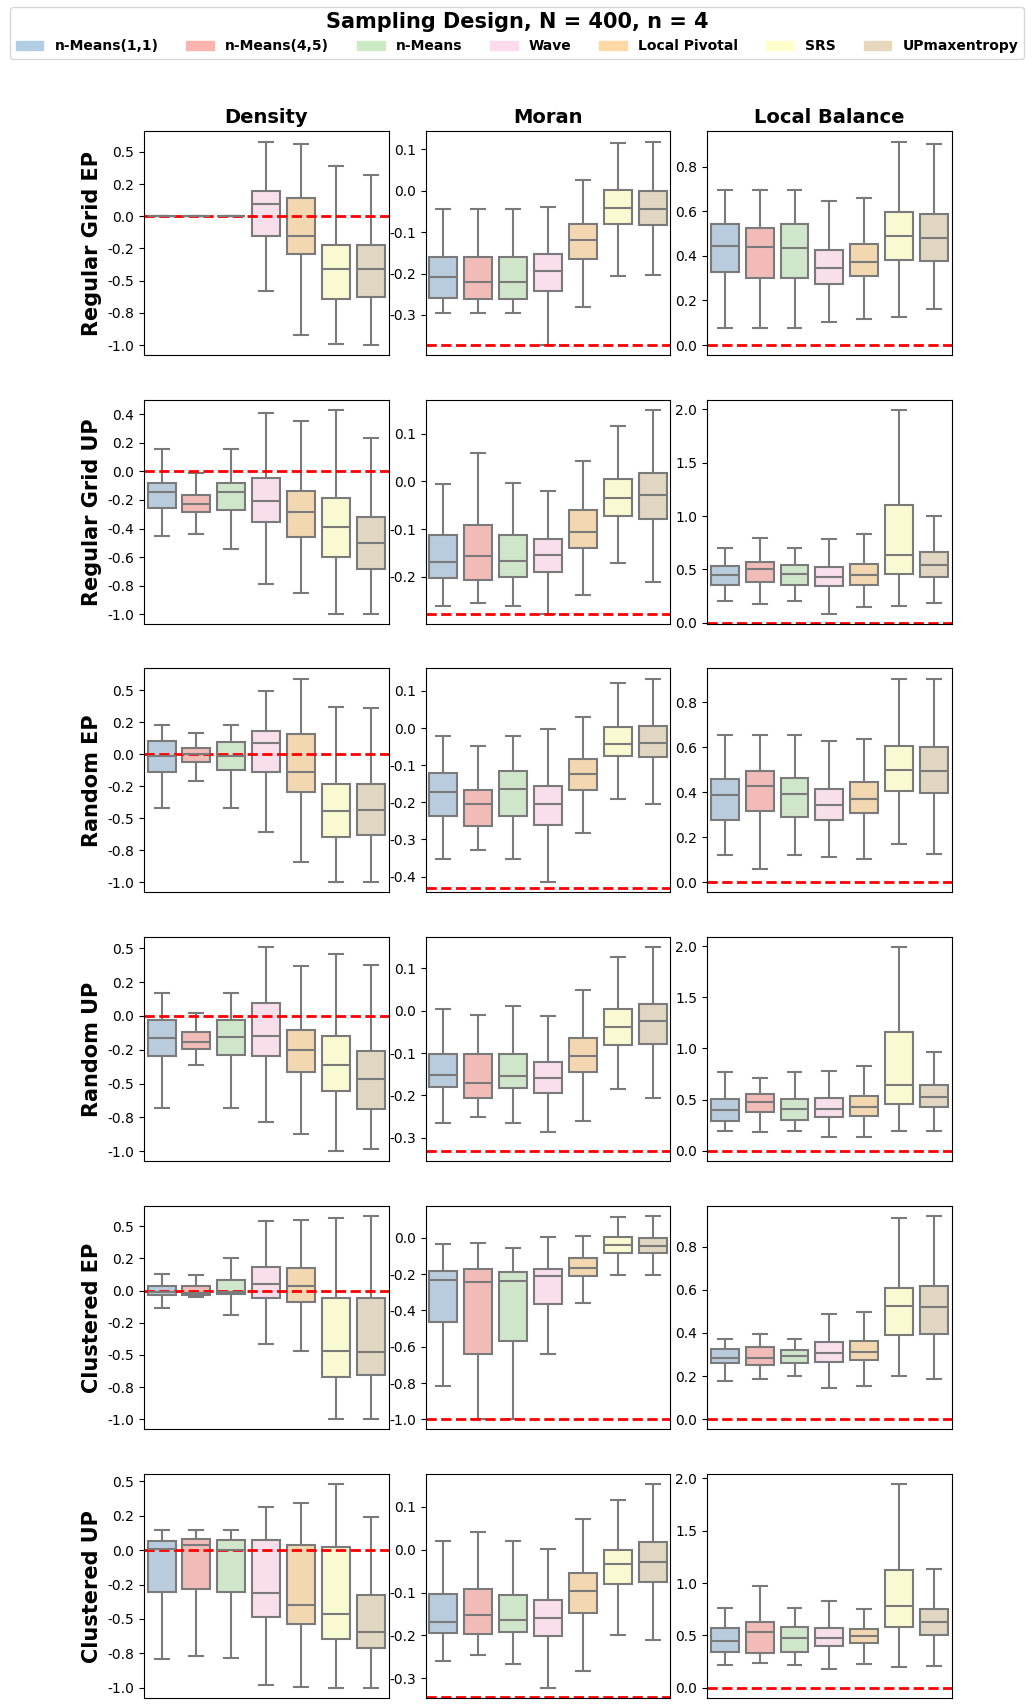

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

# Folder and file info
method_order = ["n-Means(1,1)", "n-Means(11)2", "origin", "mahatan", "project", "Local Pivotal", "Wave", "SRS", "UPmaxentropy"]
method_order = ["n-Means(1,1)", "n-Means(4,5)", 'n-Means', "Wave", "Local Pivotal",  "SRS", "UPmaxentropy"]
results_folder = 'data_samples/results'
result_files = [
    "results_grid_eq.csv",
    "results_grid_uneq.csv",
    "results_random_eq.csv",
    "results_random_uneq.csv",
    "results_clust_eq.csv",
    "results_clust_uneq.csv",
    # "results_swiss_eq_n=10.csv",
    # "results_swiss_uneq_n=10.csv",
]
pretty_names = {
    "grid_eq": "Regular Grid Equal FIP",
    "grid_uneq": "Regular Grid Unequal FIP",
    "random_eq": "Random Equal FIP",
    "random_uneq": "Random Unequal FIP",
    "clust_eq": "Clustered Equal FIP",
    "clust_uneq": "Clustered Unequal FIP",
}

pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}

# Use the new column for plotting (x or hue):
pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
colnames = ["Method", "Density", "Moran", "Voronoi"]
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname))#names=colnames, header=True)
    results_dict[name] = df
print(df)
# Mapping for nicer method names
method_name_mapping = {
    #"K-Means (11_lexsort)": "n-Means(11)",
    # "K-Means (11_lexsort2)": "n-Means(11)2",
    # "K-Means (11_origin)": "origin",
    # "K-Means (11_mahatan)": "mahatan",
    "K-Means (11_random_)": "n-Means(1,1)",
    "K-Means (45_random_)": "n-Means(4,5)",
    "K-Means (11_lexsortxy)": "n-Means",
    "wave": "Wave",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy"
}

# Apply the mapping to ALL dataframes in your results_dict
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)

# OPTIONAL: Remove any 'Method Pretty' columns if you made them previously
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
# Method palette for coloring
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))

# Metrics
columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]
#columns = [columns[i] for i in [0, 2, 1, 3]]

# Create 6x4 grid (6 populations, 4 metrics)
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric] < 2],  # <--- Filter here!
#            data=df_pop, #remove_outliers(df_pop, metric, IQR_coef=10, groupby_col="Method"),
            hue="Method",  # always assign hue for consistent handles
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
            #boxprops=dict(color='black'),
            #whiskerprops=dict(color='black'),
            #capprops=dict(color='black'),
            #medianprops=dict(color='black'),
        )
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
        ax.tick_params(axis='x', length=0)  # This removes the little black lines (ticks) on the x-axis
        #ax.grid(True)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if not (row_idx == 0 and col_idx == 0):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 2 decimals
        if metric in ['Density', 'Voronoi', 'Local Balance']:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
        else:
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=2)
# ... rest of your code as above ...

# ----------- SHARED LEGEND BLOCK (robust dummy plot method) -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)

# NOTE: Only use x="Method", NOT hue!
sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)

from matplotlib.patches import Patch
labels = method_order
handles = [Patch(color=method_palette[l]) for l in labels]
plt.close(fig_legend)
leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(all_methods),
    title="Sampling Design, N = 400, n = 4",
    fontsize=10,              # Label size
    title_fontsize=15         # Title size
    # No fontweight argument directly here
)

# Make legend labels bold
for text in leg.get_texts():
    text.set_fontweight('bold')

# Make legend title bold
leg.get_title().set_fontweight('bold')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.2)
# fig.suptitle("All metrics for all populations", fontsize=16, y=1.01)
plt.show()